In [1]:
# Hit Prediction on cleaned dataset

import warnings, os
warnings.filterwarnings("ignore")

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier

import joblib



In [2]:
# Configuration
RANDOM_STATE = 42
TEST_SIZE = 0.20
THRESH_GRID = np.linspace(0.30, 0.70, 41)  # threshold sweep
INPUT_CSV = "songs_cleaned_ready.csv"

In [3]:
# Load the data
df = pd.read_csv(INPUT_CSV, low_memory=False)

# Drop rows missing the target
if "is_hit" not in df.columns:
    raise ValueError("Expected 'is_hit' column.")

df = df.dropna(subset=["is_hit"]).copy()
df["is_hit"] = df["is_hit"].astype(int)

# Drop leftover text-heavy columns which are not suitable for ML
raw_text_cols = [c for c in ["artist_genres", "artist_genres_simple", "label"] if c in df.columns]
df = df.drop(columns=raw_text_cols, errors="ignore")

print("Dataset size:", len(df))
print("Columns after cleanup:", df.columns.tolist()[:20], "...")


Dataset size: 81207
Columns after cleanup: ['duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre', 'num_artists', 'available_markets_count', 'album_type', 'total_tracks_in_album', 'artist_popularity'] ...


In [4]:
# X / y
y = df["is_hit"].astype(int)
X = df.drop(columns=["is_hit"], errors="ignore")

# Find categorical features
candidate_cats = [c for c in X.columns if X[c].dtype == "object"]
preferred_cats = [c for c in ["album_type", "label_group", "track_genre"] if c in X.columns]
other_cats = [c for c in candidate_cats if c not in preferred_cats]

if other_cats:
    print("Note: additional object columns found:", other_cats)

categorical_features = preferred_cats + other_cats
numeric_features = [c for c in X.columns if c not in categorical_features]

print("Numeric features:", len(numeric_features))
print("Categorical features:", categorical_features)

# Preprocessor
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)


Numeric features: 82
Categorical features: ['album_type', 'label_group', 'track_genre']


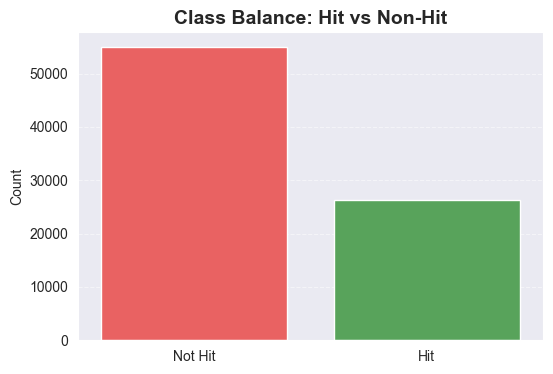

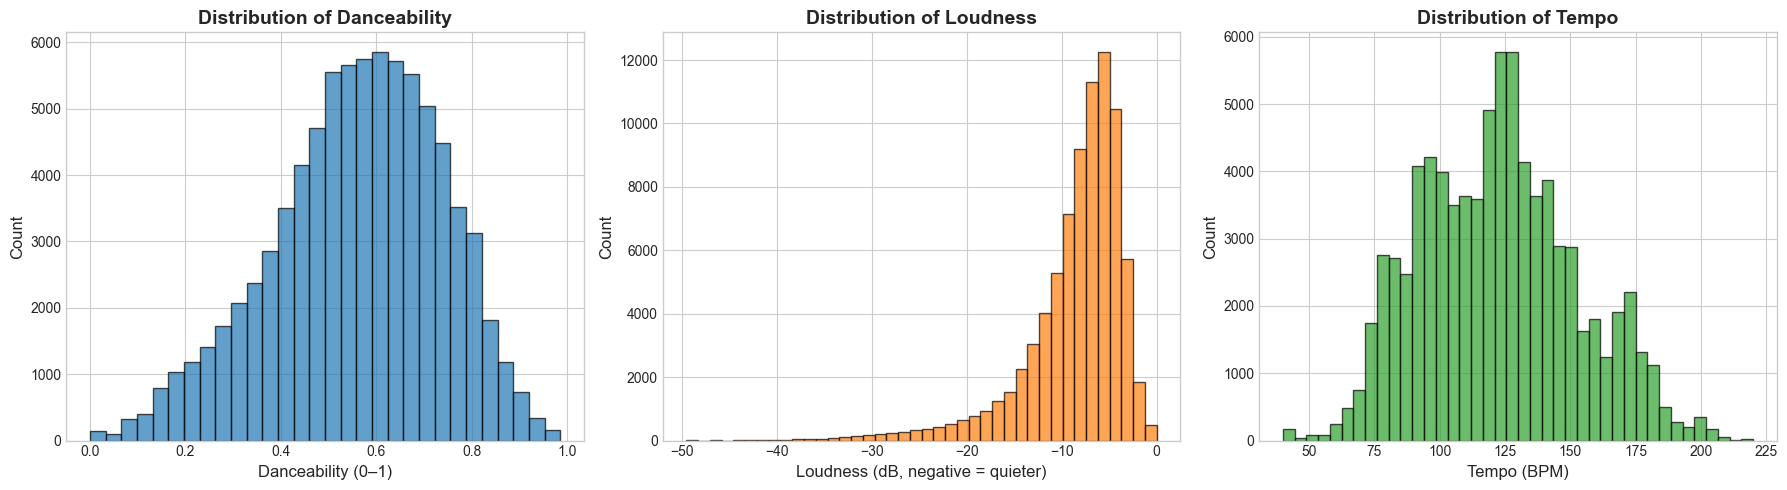

In [5]:
# 1. Class balance (Hit vs Non-Hit)

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="is_hit", palette=["#ff4c4c", "#4caf50"])
plt.xticks([0, 1], ["Not Hit", "Hit"])
plt.title("Class Balance: Hit vs Non-Hit", fontsize=14, weight="bold")
plt.xlabel("")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

#Plot 2
# Set style
plt.style.use("seaborn-v0_8-whitegrid")
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Feature list
features = [
    ("danceability", "Danceability (0–1)"),
    ("loudness", "Loudness (dB, negative = quieter)"),
    ("tempo", "Tempo (BPM)")
]

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (col, label) in enumerate(features):
    ax = axes[i]
    data = pd.to_numeric(df[col], errors="coerce").dropna()

    # Clip to reasonable range for clarity
    if col == "danceability":
        data = data.clip(0, 1)
        bins = 30
    elif col == "loudness":
        data = data.clip(-60, 0)
        bins = 40
    elif col == "tempo":
        data = data.clip(40, 220)
        bins = 40

    ax.hist(data, bins=bins, color=colors[i], alpha=0.7, edgecolor="black")
    ax.set_title(f"Distribution of {col.capitalize()}", fontsize=14, weight="bold")
    ax.set_xlabel(label, fontsize=12)
    ax.set_ylabel("Count", fontsize=12)

plt.tight_layout()
plt.show()




In [6]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)
print(f"Rows: {len(df):,} | Train: {X_train.shape} | Test: {X_test.shape}")
print("Hit rate (test):", f"{y_test.mean()*100:.2f}%")

#  Base Models
log_reg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=400, max_depth=18, n_jobs=-1, random_state=RANDOM_STATE)
xgb = XGBClassifier(
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist"
)


Rows: 81,207 | Train: (64965, 85) | Test: (16242, 85)
Hit rate (test): 32.29%


In [7]:
# XGB tuning
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

param_dist = {
    "n_estimators": [400, 700, 1000],
    "max_depth": [6, 8, 10],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bytree": [0.7, 0.85, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 1, 3]
}

xgb_pipe = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", xgb)
])

search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions={"clf__"+k: v for k, v in param_dist.items()},
    n_iter=25,
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
search.fit(X_train, y_train)

print("\nBest XGB parameters:", search.best_params_)
best_xgb_pipe = search.best_estimator_


Fitting 3 folds for each of 25 candidates, totalling 75 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for 


Best XGB parameters: {'clf__subsample': 0.85, 'clf__n_estimators': 1000, 'clf__min_child_weight': 1, 'clf__max_depth': 10, 'clf__learning_rate': 0.03, 'clf__gamma': 1, 'clf__colsample_bytree': 0.7}


In [8]:
# Evaluate tuned XGB
xgb_proba = best_xgb_pipe.predict_proba(X_test)[:, 1]
xgb_pred05 = (xgb_proba >= 0.50).astype(int)

print("\nTuned XGBoost:")
print(classification_report(y_test, xgb_pred05, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, xgb_proba))



Tuned XGBoost:
              precision    recall  f1-score   support

           0      0.909     0.918     0.913     10997
           1      0.824     0.807     0.815      5245

    accuracy                          0.882     16242
   macro avg      0.866     0.862     0.864     16242
weighted avg      0.881     0.882     0.882     16242

ROC-AUC: 0.9487533431641335


In [9]:
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")

log_reg_pipe = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", log_reg)
])

log_reg_pipe.fit(X_train, y_train)
y_proba_lr = log_reg_pipe.predict_proba(X_test)[:,1]
y_pred_lr = (y_proba_lr >= 0.5).astype(int)

print("\nLogistic Regression:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))



Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     10997
           1       0.69      0.83      0.75      5245

    accuracy                           0.82     16242
   macro avg       0.80      0.83      0.81     16242
weighted avg       0.84      0.82      0.83     16242

ROC-AUC: 0.904203009521706


In [10]:
rf = RandomForestClassifier(
    n_estimators=400, max_depth=18,
    n_jobs=-1, random_state=42
)

rf_pipe = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", rf)
])

rf_pipe.fit(X_train, y_train)
y_proba_rf = rf_pipe.predict_proba(X_test)[:,1]
y_pred_rf = (y_proba_rf >= 0.5).astype(int)

print("\nRandom Forest:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))



Random Forest:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88     10997
           1       0.73      0.81      0.77      5245

    accuracy                           0.84     16242
   macro avg       0.82      0.84      0.83     16242
weighted avg       0.85      0.84      0.85     16242

ROC-AUC: 0.920152918037357


In [11]:
xgb = XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1)

xgb_pipe = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", xgb)
])

xgb_pipe.fit(X_train, y_train)
y_proba_xgb = xgb_pipe.predict_proba(X_test)[:,1]
y_pred_xgb = (y_proba_xgb >= 0.5).astype(int)

print("\nXGBoost:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))



XGBoost:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     10997
           1       0.79      0.80      0.80      5245

    accuracy                           0.87     16242
   macro avg       0.85      0.85      0.85     16242
weighted avg       0.87      0.87      0.87     16242

ROC-AUC: 0.9382718209047912


In [12]:
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42,
    n_jobs=-1
)

lgbm_pipe = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", lgbm)
])

lgbm_pipe.fit(X_train, y_train)
y_proba_lgbm = lgbm_pipe.predict_proba(X_test)[:,1]
y_pred_lgbm = (y_proba_lgbm >= 0.5).astype(int)

print("\nLightGBM:")
print(classification_report(y_test, y_pred_lgbm))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lgbm))


[LightGBM] [Info] Number of positive: 43987, number of negative: 43987
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21741
[LightGBM] [Info] Number of data points in the train set: 87974, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

LightGBM:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91     10997
           1       0.81      0.80      0.81      5245

    accuracy                           0.88     16242
   macro avg       0.86      0.86      0.86     16242
weighted avg       0.88      0.88      0.88     16242

ROC-AUC: 0.9429500185205203


In [13]:
cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    random_seed=42,
    verbose=100
)

cat_pipe = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", cat)
])

cat_pipe.fit(X_train, y_train)
y_proba_cat = cat_pipe.predict_proba(X_test)[:,1]
y_pred_cat = (y_proba_cat >= 0.5).astype(int)

print("\nCatBoost:")
print(classification_report(y_test, y_pred_cat))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_cat))


0:	learn: 0.6624953	total: 94.2ms	remaining: 47s
100:	learn: 0.3337216	total: 2.65s	remaining: 10.5s
200:	learn: 0.2859255	total: 10.3s	remaining: 15.3s
300:	learn: 0.2513980	total: 12.9s	remaining: 8.55s
400:	learn: 0.2295620	total: 15.5s	remaining: 3.84s
499:	learn: 0.2146348	total: 18.2s	remaining: 0us

CatBoost:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     10997
           1       0.81      0.80      0.81      5245

    accuracy                           0.87     16242
   macro avg       0.86      0.86      0.86     16242
weighted avg       0.87      0.87      0.87     16242

ROC-AUC: 0.9417718134931158


In [14]:
# Load a small sample
df = pd.read_csv("songs_cleaned_ready.csv", low_memory=False)
sample = df[["duration_ms","tempo","loudness","energy","valence","danceability"]].head(1).copy()

# Feature Engineering
def safe_log1p(x):
    return np.log1p(np.clip(x, a_min=0, a_max=None))

sample["log_duration"] = safe_log1p(sample["duration_ms"])
sample["log_tempo"] = safe_log1p(sample["tempo"])
sample["log_loudness"] = safe_log1p((-sample["loudness"]).clip(lower=0))

sample["energy_valence"] = sample["energy"] * sample["valence"]
sample["dance_tempo"] = sample["danceability"] * sample["tempo"]

print("BEFORE (original features)")
print(df[["duration_ms","tempo","loudness","energy","valence","danceability"]].head(1))

print("\nAFTER (engineered features added)")
print(sample[[
    "log_duration","log_tempo",
    "log_loudness","energy_valence","dance_tempo"
]])


BEFORE (original features)
   duration_ms   tempo  loudness  energy  valence  danceability
0     230666.0  87.917    -6.746   0.461    0.715         0.676

AFTER (engineered features added)
   log_duration  log_tempo  log_loudness  energy_valence  dance_tempo
0      12.34873   4.487703      2.047177        0.329615    59.431892


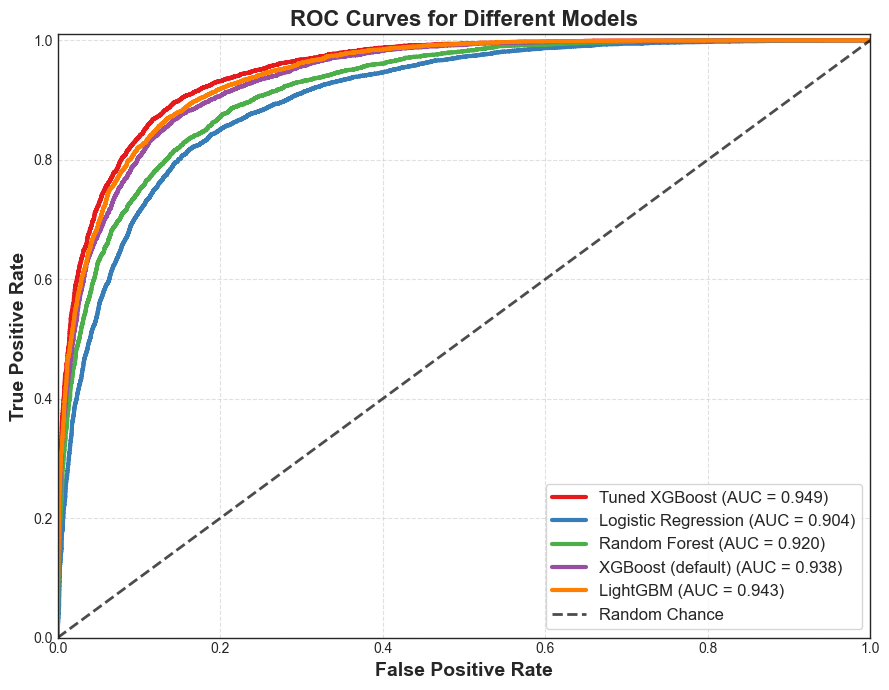

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# White background
sns.set_style("white")
plt.figure(figsize=(9, 7))

# Plot each model
models = {
    "Tuned XGBoost": xgb_proba,
    "Logistic Regression": y_proba_lr,
    "Random Forest": y_proba_rf,
    "XGBoost (default)": y_proba_xgb,
    "LightGBM": y_proba_lgbm
}

# Bright, standout palette
colors = sns.color_palette("Set1", len(models))

for (name, probs), color in zip(models.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_score = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, lw=3, color=color,
             label=f"{name} (AUC = {auc_score:.3f})")

# Random chance line
plt.plot([0, 1], [0, 1], "k--", lw=2, alpha=0.7, label="Random Chance")

# Formatting
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.xlabel("False Positive Rate", fontsize=14, weight="bold")
plt.ylabel("True Positive Rate", fontsize=14, weight="bold")
plt.title("ROC Curves for Different Models", fontsize=16, weight="bold")
plt.legend(loc="lower right", fontsize=12, frameon=True)
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()
